In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the Data
df = pd.read_csv('FTSE Malaysia KLCI Historical Data (2).csv')

# 2. Fix the "Date" Column
# The raw data is likely sorted Newest -> Oldest.
# sort Oldest -> Newest to learn the sequence of time for lstm model.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# 3. Fix the "Price", "Open", "High", "Low" Columns
#  remove ',' and turn them into numbers.
cols_to_fix = ['Price', 'Open', 'High', 'Low']
for col in cols_to_fix:
    # Remove comma and convert to float
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 4. Fix the "Vol." (Volume) Column
# It has "M" for Millions and "K" for Thousands (e.g., "26.77M").
def clean_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x == '-': return 0
        if 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        if 'K' in x:
            return float(x.replace('K', '')) * 1_000
    return float(x)

df['Vol.'] = df['Vol.'].apply(clean_volume)

# 5. Fix "Change %"
# Remove the '%' sign and convert to float
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

# Check if it worked
print("Data Cleaned Successfully")
print(df.info())
print(df.head())

Data Cleaned Successfully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2451 non-null   datetime64[ns]
 1   Price     2451 non-null   float64       
 2   Open      2451 non-null   float64       
 3   High      2451 non-null   float64       
 4   Low       2451 non-null   float64       
 5   Vol.      2450 non-null   float64       
 6   Change %  2451 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 134.2 KB
None
        Date    Price     Open     High      Low         Vol.  Change %
0 2015-11-19  1660.06  1657.09  1664.30  1655.99  109630000.0      0.21
1 2015-11-20  1661.89  1660.17  1663.48  1657.13  104970000.0      0.11
2 2015-11-23  1670.90  1661.59  1673.92  1661.59  106120000.0      0.54
3 2015-11-24  1677.03  1678.68  1686.69  1677.03  142980000.0      0.37
4 2015-11-25  1684.42  1672.

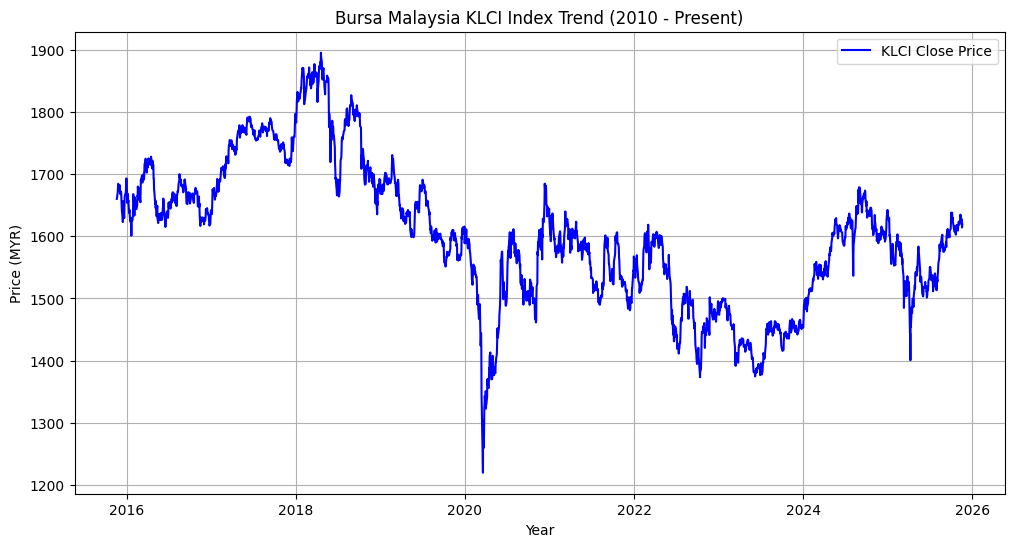

In [ ]:
# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='KLCI Close Price', color='blue')
plt.title('Bursa Malaysia KLCI Index Trend (2010 - Present)')
plt.xlabel('Year')
plt.ylabel('Price (MYR)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. Select the Target Column
# We are forecasting the 'Price' (Closing Price)
data = df['Price'].values.reshape(-1, 1)

# 2. Normalize the Data
# The paper specifically uses Min-Max Normalization to scale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Define the Sliding Window Function
# This converts a simple list of numbers into a format LSTM can learn:
# Input (X): Day 1 to Day 20
# Output (y): Day 21
def create_dataset(dataset, look_back=20):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 4. Apply the Window
# The research paper found a look-back of 20 days gave the best results
look_back = 20
X, y = create_dataset(scaled_data, look_back)

# 5. Split into Training and Testing
# The paper used a 70% Training / 30% Testing split
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# 6. Reshape for LSTM
# LSTM needs 3D input: [Samples, Time Steps, Features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (1701, 20, 1)
Testing Data Shape: (730, 20, 1)


Epoch 1/64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.1391 - val_loss: 0.0025
Epoch 2/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 3/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 4/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0021 - val_loss: 8.8017e-04
Epoch 5/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0017 - val_loss: 8.3286e-04
Epoch 6/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0016 - val_loss: 8.0836e-04
Epoch 7/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 7.9619e-04
Epoch 8/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 8.1226e-04
Epoch 9/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0016 - val_loss: 7.7073e-04
Epoch 10/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - val_loss: 7.7547e-04
Epoch 11/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0014 - val_loss: 7.4600e-04
Epoch 12/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 

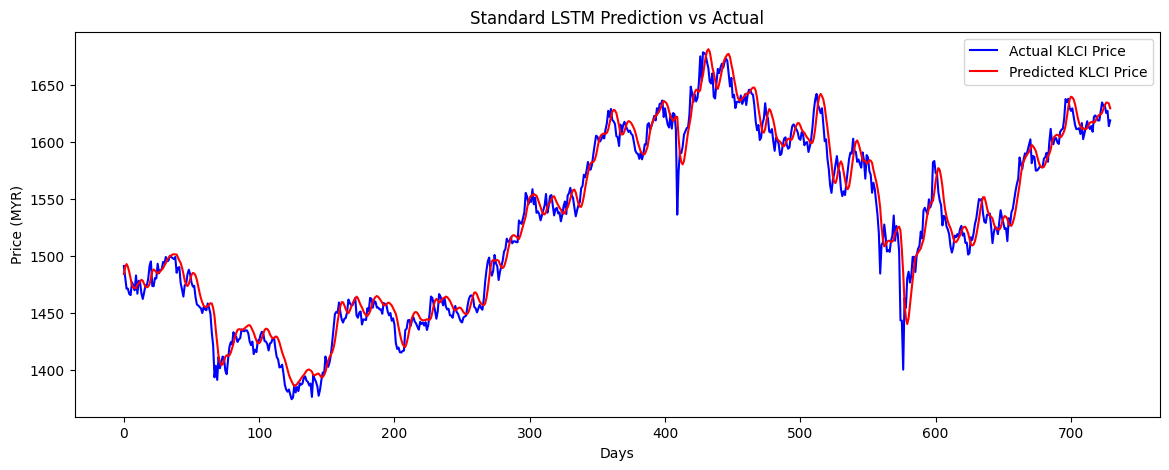

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Define the "Standard" LSTM Model Structure
# (Parameters taken from Table 1 of the paper)
model = Sequential()

# Layer 1: 100 Neurons, return_sequences=True because there is another LSTM layer after this
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Layer 2: 20 Neurons, return_sequences=False because next is the output layer
model.add(LSTM(units=20, return_sequences=False))

# Output Layer: Predicts 1 value (the Stock Price)
model.add(Dense(units=1))

# 2. Compile the Model
# The paper specifies a Learning Rate of 0.001 and MSE loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 3. Train the Model
# The paper specifies Epochs=64 and Batch_size=64
history = model.fit(
    X_train, y_train,
    epochs=64,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# 4. Make Predictions
predictions = model.predict(X_test)

# 5. Inverse Transform (Convert '0.55' back to '1600 MYR')
# We utilize the 'scaler' we created in the previous step
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Evaluation Metrics
# Calculate RMSE, MAE, MAPE, and R2
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_actual, predictions_actual)

print(f"\n--- Standard LSTM Results ---")
print(f"RMSE: {rmse}")
print(f"MAE:  {mae}")
print(f"MAPE: {mape}%")
print(f"R2:   {r2}")

# 7. Plot the Results
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual KLCI Price')
plt.plot(predictions_actual, color='red', label='Predicted KLCI Price')
plt.title('Standard LSTM Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Price (MYR)')
plt.legend()
plt.show()

In [ ]:
# Plot Training Loss vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Progress')
plt.ylabel('Error (MSE)')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 1. Predict on Training Data
train_predictions = model.predict(X_train)
train_predictions_actual = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# 2. Calculate Metrics for Training
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predictions_actual))

# 3. Compare with Testing Metrics (from previous step)
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing  RMSE: {rmse:.2f}")

if train_rmse < (rmse * 0.5):
    print("\nWARNING: Possible Overfitting detected! (Training error is much lower than Testing error)")
else:
    print("\nSTATUS: Model looks healthy (Training and Testing errors are balanced).")

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Training RMSE: 16.92
Testing  RMSE: 13.58

STATUS: Model looks healthy (Training and Testing errors are balanced).


Data Cleaned Successfully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2451 non-null   datetime64[ns]
 1   Price     2451 non-null   float64       
 2   Open      2451 non-null   float64       
 3   High      2451 non-null   float64       
 4   Low       2451 non-null   float64       
 5   Vol.      2450 non-null   float64       
 6   Change %  2451 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 134.2 KB
None
        Date    Price     Open     High      Low         Vol.  Change %
0 2015-11-19  1660.06  1657.09  1664.30  1655.99  109630000.0      0.21
1 2015-11-20  1661.89  1660.17  1663.48  1657.13  104970000.0      0.11
2 2015-11-23  1670.90  1661.59  1673.92  1661.59  106120000.0      0.54
3 2015-11-24  1677.03  1678.68  1686.69  1677.03  142980000.0      0.37
4 2015-11-25  1684.42  1672.

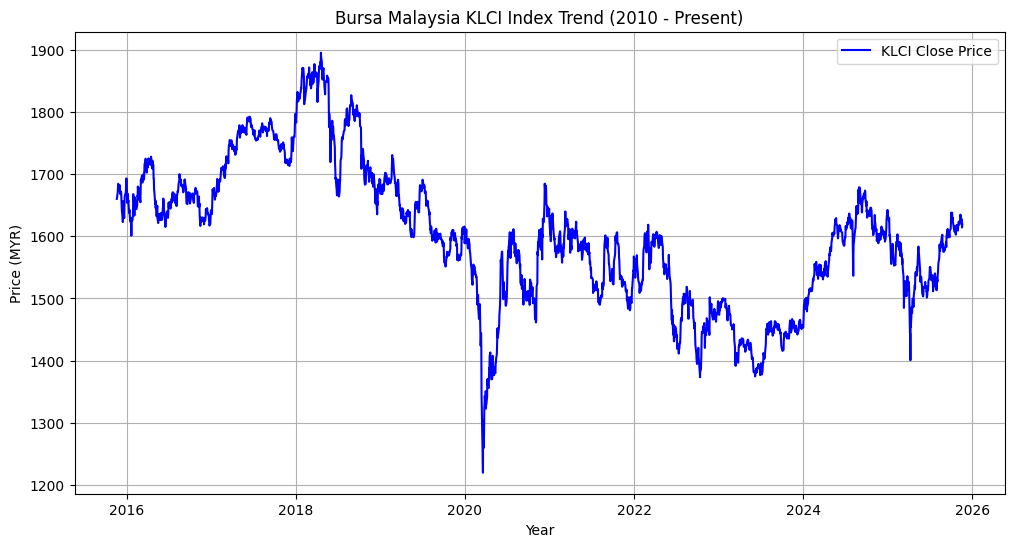

Training Data Shape: (1701, 20, 1)
Testing Data Shape: (730, 20, 1)
Epoch 1/64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.1405 - val_loss: 0.0025
Epoch 2/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 3/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 4/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0024 - val_loss: 9.4843e-04
Epoch 5/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0019 - val_loss: 8.7827e-04
Epoch 6/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - val_loss: 8.6435e-04
Epoch 7/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0017 - val_loss: 8.3044e-04
Epoch 8/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016 - val_loss: 8.1602e-04
Epoch 9/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015 - val_loss: 8.0321e-04
Epoch 10/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016 - val_loss: 7.9896e-04
Epoch 11/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015 - val_loss: 7.8621e-04
Epoch 12/64
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 

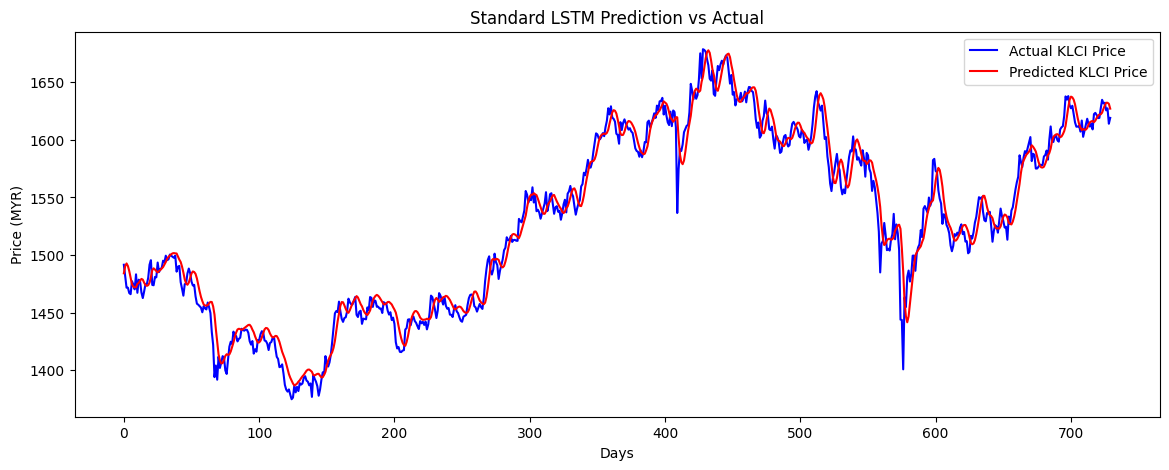

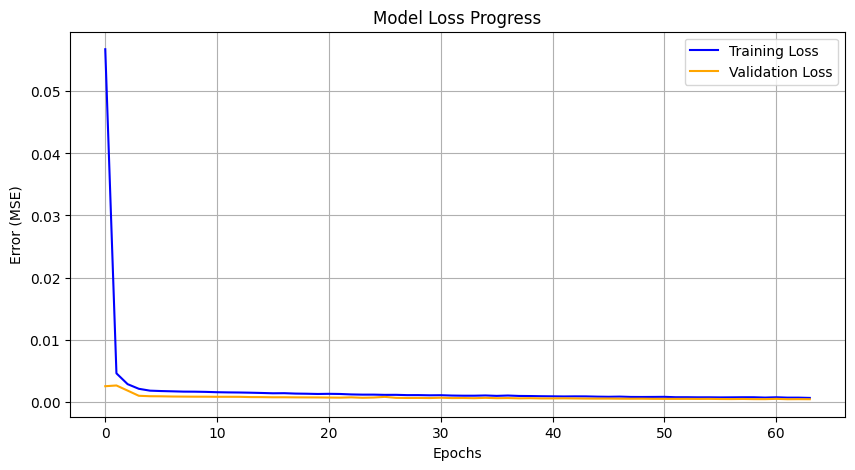

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Training RMSE: 16.46
Testing  RMSE: 13.42

STATUS: Model looks healthy (Training and Testing errors are balanced).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load the Data
df = pd.read_csv('FTSE Malaysia KLCI Historical Data (2).csv')

# 2. Fix the "Date" Column
# The raw data is likely sorted Newest -> Oldest.
# LSTMs need Oldest -> Newest to learn the sequence of time.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# 3. Fix the "Price", "Open", "High", "Low" Columns
# They are strings with commas (e.g., "1,619.11"). We need to remove ',' and turn them into numbers.
cols_to_fix = ['Price', 'Open', 'High', 'Low']
for col in cols_to_fix:
    # Remove comma and convert to float
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 4. Fix the "Vol." (Volume) Column
# It has "M" for Millions and "K" for Thousands
def clean_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x == '-': return 0
        if 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        if 'K' in x:
            return float(x.replace('K', '')) * 1_000
    return float(x)

df['Vol.'] = df['Vol.'].apply(clean_volume)

# 5. Fix "Change %"
# Remove the '%' sign and convert to float
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

print("Data Cleaned Successfully")
print(df.info())
print(df.head())

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='KLCI Close Price', color='blue')
plt.title('Bursa Malaysia KLCI Index Trend (2010 - Present)')
plt.xlabel('Year')
plt.ylabel('Price (MYR)')
plt.legend()
plt.grid(True)
plt.show()

# 1. Select the Target Column
#  forecasting the 'Price' (Closing Price)
data = df['Price'].values.reshape(-1, 1)

# 2. Normalize the Data
# use Min-Max Normalization to scale data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Define the Sliding Window Function
# This converts a simple list of numbers into a format LSTM can learn:
# Input (X): Day 1 to Day 20
# Output (y): Day 21
def create_dataset(dataset, look_back=20):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# 4. Apply the Window
look_back = 20
X, y = create_dataset(scaled_data, look_back)

# 5. Split into Training and Testing
# The paper used a 70% Training / 30% Testing split
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# 6. Reshape for LSTM
# LSTM needs 3D input: [Samples, Time Steps, Features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# 1. Define the "Standard" LSTM Model Structure
# (Parameters taken from Table 1 of the paper)
model = Sequential()

# Layer 1: 100 Neurons, return_sequences=True because there is another LSTM layer after this
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Layer 2: 20 Neurons, return_sequences=False because next is the output layer
model.add(LSTM(units=20, return_sequences=False))

# Output Layer: Predicts 1 value (the Stock Price)
model.add(Dense(units=1))

# 2. Compile the Model
# The paper specifies a Learning Rate of 0.001 and MSE loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 3. Train the Model
# The paper specifies Epochs=64 and Batch_size=64
history = model.fit(
    X_train, y_train,
    epochs=64,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

# 4. Make Predictions
predictions = model.predict(X_test)

# 5. Inverse Transform (Convert '0.55' back to '1600 MYR')
# We utilize the 'scaler' we created in the previous step
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Evaluation Metrics
# Calculate RMSE, MAE, MAPE, and R2 as used in the paper
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_actual, predictions_actual)

print(f"\n--- Standard LSTM Results ---")
print(f"RMSE: {rmse}")
print(f"MAE:  {mae}")
print(f"MAPE: {mape}%")
print(f"R2:   {r2}")

# 7. Plot the Results
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual KLCI Price')
plt.plot(predictions_actual, color='red', label='Predicted KLCI Price')
plt.title('Standard LSTM Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Price (MYR)')
plt.legend()
plt.show()

# Plot Training Loss vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Progress')
plt.ylabel('Error (MSE)')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 1. Predict on Training Data
train_predictions = model.predict(X_train)
train_predictions_actual = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# 2. Calculate Metrics for Training
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predictions_actual))

# 3. Compare with Testing Metrics (from previous step)
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing  RMSE: {rmse:.2f}")

if train_rmse < (rmse * 0.5):
    print("\nWARNING: Possible Overfitting detected! (Training error is much lower than Testing error)")
else:
    print("\nSTATUS: Model looks healthy (Training and Testing errors are balanced).")

Training Data: 1960 days
Testing Data:  490 days

Model Accuracy: 46.94%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.46      0.50      0.48       238
           1       0.48      0.44      0.46       252

    accuracy                           0.47       490
   macro avg       0.47      0.47      0.47       490
weighted avg       0.47      0.47      0.47       490



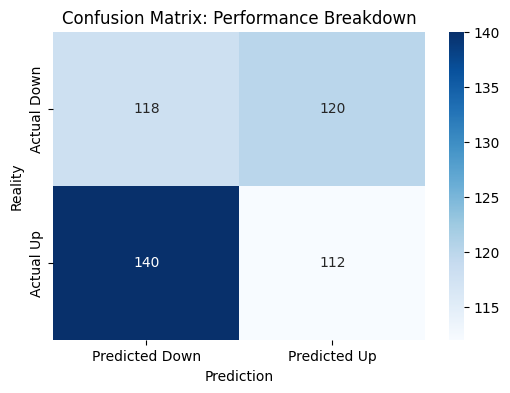

Generating Trend Plot...


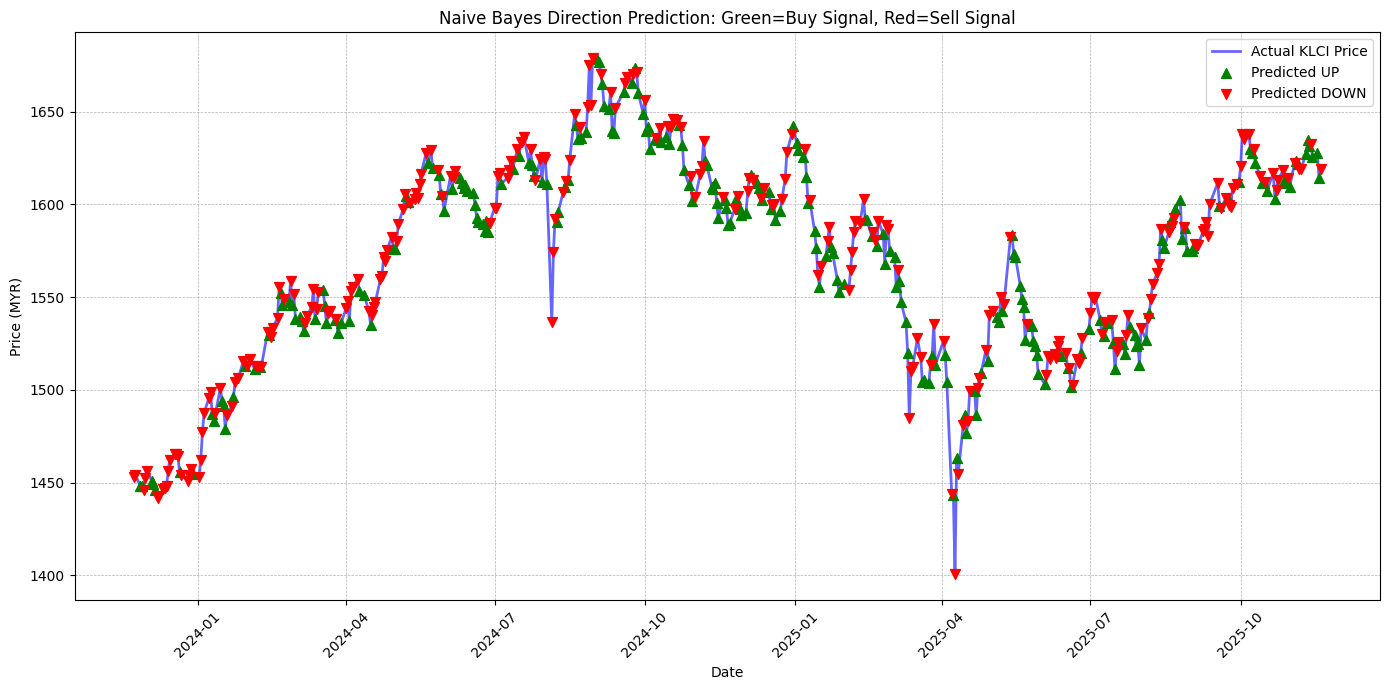

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# 1. LOAD AND CLEAN DATA

try:
    df = pd.read_csv('FTSE Malaysia KLCI Historical Data (2).csv')
except FileNotFoundError:
    print("Error: 'FTSE Malaysia KLCI Historical Data (2).csv' not found.")
    exit()

# Fix Date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# Fix Numbers (Remove commas)
cols_to_fix = ['Price', 'Open', 'High', 'Low']
for col in cols_to_fix:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Fix Volume (Convert K/M to numbers)
def clean_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x == '-': return 0
        if 'M' in x: return float(x.replace('M', '')) * 1_000_000
        if 'K' in x: return float(x.replace('K', '')) * 1_000
    return float(x)
df['Vol.'] = df['Vol.'].apply(clean_volume)


# 2. FEATURE ENGINEERING
# Create features to represent market state
df['Open-Close'] = df['Open'] - df['Price']
df['High-Low'] = df['High'] - df['Low']
df['Vol_Increase'] = np.where(df['Vol.'] > df['Vol.'].shift(1), 1, 0)

# Drop NaN values created by shifting
df = df.dropna()

# Create Target: 1 if Tomorrow's Price > Today's Price, else 0
df['Target'] = np.where(df['Price'].shift(-1) > df['Price'], 1, 0)

# 3. SPLIT DATA
features = ['Open-Close', 'High-Low', 'Vol_Increase']
X = df[features]
y = df['Target']

# Sequential split (80% Train, 20% Test)
split = int(len(df) * 0.8)
X_train = X.iloc[:split]
y_train = y.iloc[:split]
X_test = X.iloc[split:]
y_test = y.iloc[split:]

print(f"Training Data: {len(X_train)} days")
print(f"Testing Data:  {len(X_test)} days")


# 4. TRAIN MODEL
model = GaussianNB()
model.fit(X_train, y_train)

# Make Predictions
predictions = model.predict(X_test)

# 5. EVALUATION METRICS
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\n--- Classification Report ---")
print(classification_report(y_test, predictions))

# 6. VISUALIZATION 1: CONFUSION MATRIX
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Down', 'Predicted Up'],
            yticklabels=['Actual Down', 'Actual Up'])
plt.xlabel('Prediction')
plt.ylabel('Reality')
plt.title('Confusion Matrix: Performance Breakdown')
plt.show()

# 7. VISUALIZATION 2: MARKET TREND PLOT
# Get the actual prices and dates for the test period
test_prices = df.loc[X_test.index, 'Price']
test_dates = df.loc[X_test.index, 'Date']

plt.figure(figsize=(14, 7))

# Plot the Actual Price Line (Blue)
plt.plot(test_dates, test_prices, label='Actual KLCI Price', color='blue', linewidth=2, alpha=0.6)

# Create masks for Up and Down predictions
up_signals = (predictions == 1)
down_signals = (predictions == 0)

# Plot markers for "Up" predictions (Green Triangle)
plt.scatter(test_dates[up_signals], test_prices[up_signals],
            marker='^', color='green', label='Predicted UP', s=50, zorder=5)

# Plot markers for "Down" predictions (Red Triangle)
plt.scatter(test_dates[down_signals], test_prices[down_signals],
            marker='v', color='red', label='Predicted DOWN', s=50, zorder=5)

# Formatting
plt.title('Naive Bayes Direction Prediction: Green=Buy Signal, Red=Sell Signal')
plt.xlabel('Date')
plt.ylabel('Price (MYR)')
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

print("Generating Trend Plot...")
plt.show()